<a href="https://colab.research.google.com/github/duanmenghuan/Car_CRUD/blob/master/%E5%9B%BE%E7%89%87%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 获取计算硬件
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [ ]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
# 数据集文件夹路径
dataset_dir = 'fruit30_split'

In [ ]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')

In [ ]:
# 创建基础目录（如果它不存在的话）
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# 创建训练集和测试集的目录
if not os.path.exists(train_path):
    os.makedirs(train_path)

if not os.path.exists(test_path):
    os.makedirs(test_path)

print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 fruit30_split/train
测试集路径 fruit30_split/val


In [ ]:
from torchvision import datasets


In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip

--2023-12-05 01:14:28--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226278151 (216M) [application/zip]
Saving to: ‘fruit30_split.zip’

fruit30_split.zip   100%[===================>] 215.79M  67.3MB/s    in 3.6s    

2023-12-05 01:14:32 (59.4 MB/s) - ‘fruit30_split.zip’ saved [226278151/226278151]



In [ ]:
# 解压
!unzip fruit30_split.zip >> /dev/null

In [ ]:
# 删除压缩包
!rm fruit30_split.zip

In [ ]:
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集图像数量 4375
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']
测试集图像数量 1078
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


In [ ]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [ ]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

In [ ]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [ ]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.1MB/s]


In [ ]:
model.fc

Linear(in_features=512, out_features=30, bias=True)

In [ ]:
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择二：微调训练所有层

In [ ]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层

In [ ]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 训练轮次 Epoch
EPOCHS = 30

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''

    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值

    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')

    return log_train

In [ ]:
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)

    log_test = {}
    log_test['epoch'] = epoch

    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')

    return log_test

In [ ]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [ ]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [ ]:
df_train_log

,epoch,batch,train_loss,train_accuracy
0,0,0,3.7191212,0.03125


In [ ]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [ ]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,3.60467,0.026902,0.020736,0.026983,0.019693


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

wandb.init(project='fruit30', name=time.strftime('%m%d%H%M%S'))

wandb: Currently logged in as: duan148299. Use `wandb login --relogin` to force relogin


In [ ]:
for epoch in range(1, EPOCHS+1):

    print(f'Epoch {epoch}/{EPOCHS}')

    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        wandb.log(log_train)

    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    wandb.log(log_test)

    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy:
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

Epoch 1/30


100%|██████████| 137/137 [00:24<00:00,  5.64it/s]


保存新的最佳模型 checkpoint/best-0.829.pth
Epoch 2/30


100%|██████████| 137/137 [00:22<00:00,  6.05it/s]


保存新的最佳模型 checkpoint/best-0.831.pth
Epoch 3/30


100%|██████████| 137/137 [00:22<00:00,  6.06it/s]


保存新的最佳模型 checkpoint/best-0.846.pth
Epoch 4/30


100%|██████████| 137/137 [00:22<00:00,  6.01it/s]


保存新的最佳模型 checkpoint/best-0.861.pth
Epoch 5/30


100%|██████████| 137/137 [00:22<00:00,  6.01it/s]


Epoch 6/30


100%|██████████| 137/137 [00:23<00:00,  5.86it/s]


Epoch 7/30


100%|██████████| 137/137 [00:23<00:00,  5.91it/s]


保存新的最佳模型 checkpoint/best-0.868.pth
Epoch 8/30


100%|██████████| 137/137 [00:23<00:00,  5.84it/s]


Epoch 9/30


100%|██████████| 137/137 [00:23<00:00,  5.86it/s]


Epoch 10/30


100%|██████████| 137/137 [00:23<00:00,  5.87it/s]


Epoch 11/30


100%|██████████| 137/137 [00:23<00:00,  5.92it/s]


Epoch 12/30


100%|██████████| 137/137 [00:24<00:00,  5.49it/s]


保存新的最佳模型 checkpoint/best-0.871.pth
Epoch 13/30


100%|██████████| 137/137 [00:25<00:00,  5.46it/s]


Epoch 14/30


100%|██████████| 137/137 [00:24<00:00,  5.58it/s]


Epoch 15/30


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 16/30


100%|██████████| 137/137 [00:24<00:00,  5.62it/s]


Epoch 17/30


100%|██████████| 137/137 [00:22<00:00,  6.00it/s]


Epoch 18/30


100%|██████████| 137/137 [00:22<00:00,  6.12it/s]


Epoch 19/30


100%|██████████| 137/137 [00:23<00:00,  5.95it/s]


保存新的最佳模型 checkpoint/best-0.872.pth
Epoch 20/30


100%|██████████| 137/137 [00:22<00:00,  6.22it/s]


保存新的最佳模型 checkpoint/best-0.879.pth
Epoch 21/30


100%|██████████| 137/137 [00:22<00:00,  6.14it/s]


Epoch 22/30


100%|██████████| 137/137 [00:22<00:00,  6.12it/s]


Epoch 23/30


100%|██████████| 137/137 [00:22<00:00,  6.09it/s]


Epoch 24/30


100%|██████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 25/30


100%|██████████| 137/137 [00:22<00:00,  6.08it/s]


Epoch 26/30


100%|██████████| 137/137 [00:22<00:00,  6.11it/s]


Epoch 27/30


100%|██████████| 137/137 [00:22<00:00,  6.00it/s]


Epoch 28/30


100%|██████████| 137/137 [00:23<00:00,  5.91it/s]


Epoch 29/30


100%|██████████| 137/137 [00:23<00:00,  5.84it/s]


Epoch 30/30


100%|██████████| 137/137 [00:24<00:00,  5.51it/s]


In [ ]:
# 载入最佳模型作为当前模型
model = torch.load('checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))

In [ ]:
model.eval()
print(evaluate_testset())

{'epoch': 30, 'test_loss': 0.43239957, 'test_accuracy': 0.8794063079777366, 'test_precision': 0.8823926583220758, 'test_recall': 0.8785983807869236, 'test_f1-score': 0.8785279907161746}


In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

--2023-12-05 01:53:23--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘SimHei.ttf’

SimHei.ttf          100%[===================>]   9.58M  15.3MB/s    in 0.6s    

2023-12-05 01:53:24 (15.3 MB/s) - ‘SimHei.ttf’ saved [10050868/10050868]



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_path = '/content/SimHei.ttf'  # 更新为您的字体路径
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'SimHei'  # 设置字体名称


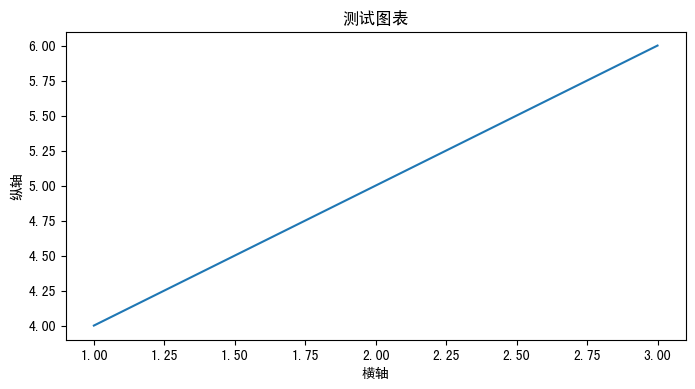

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("测试图表")
plt.xlabel("横轴")
plt.ylabel("纵轴")
plt.show()


In [ ]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [ ]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

In [ ]:
model = torch.load('/content/checkpoint/best-0.879.pth')
model = model.eval().to(device)

In [ ]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
from PIL import Image

In [ ]:
img_path = '/content/苹果.jpeg'

In [ ]:
img_pil = Image.open(img_path)

In [ ]:
np.array(img_pil).shape

(193, 214, 3)

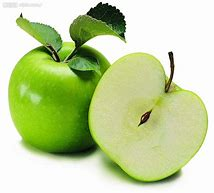

In [ ]:
img_pil

In [ ]:
input_img = test_transform(img_pil) # 预处理

In [ ]:
input_img.shape

torch.Size([3, 224, 224])

In [ ]:
input_img = input_img.unsqueeze(0).to(device)

In [ ]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
pred_logits = model(input_img)

In [ ]:
pred_logits

tensor([[ -9.4582,  -7.5836,  -4.8234,  -9.8204,  -4.6905,  -5.8747,  -8.7037,
           0.2376,  -4.3310, -11.0412,  -6.4861,  -4.0946,  -9.9306,  -9.1084,
         -11.0112, -10.5240,  -5.7441,  -6.7582,  -4.8909,   4.4929,  -8.8535,
          -7.3593, -10.0955,  -8.3925, -11.5748,  -7.1523,  -7.7336,  -5.2383,
          -6.7885,  -6.0093]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [ ]:
pred_softmax

tensor([[8.6032e-07, 5.6074e-06, 8.8616e-05, 5.9889e-07, 1.0121e-04, 3.0971e-05,
         1.8294e-06, 1.3980e-02, 1.4500e-04, 1.7667e-07, 1.6804e-05, 1.8367e-04,
         5.3638e-07, 1.2205e-06, 1.8206e-07, 2.9634e-07, 3.5292e-05, 1.2802e-05,
         8.2835e-05, 9.8519e-01, 1.5749e-06, 7.0178e-06, 4.5484e-07, 2.4974e-06,
         1.0362e-07, 8.6315e-06, 4.8263e-06, 5.8526e-05, 1.2419e-05, 2.7070e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

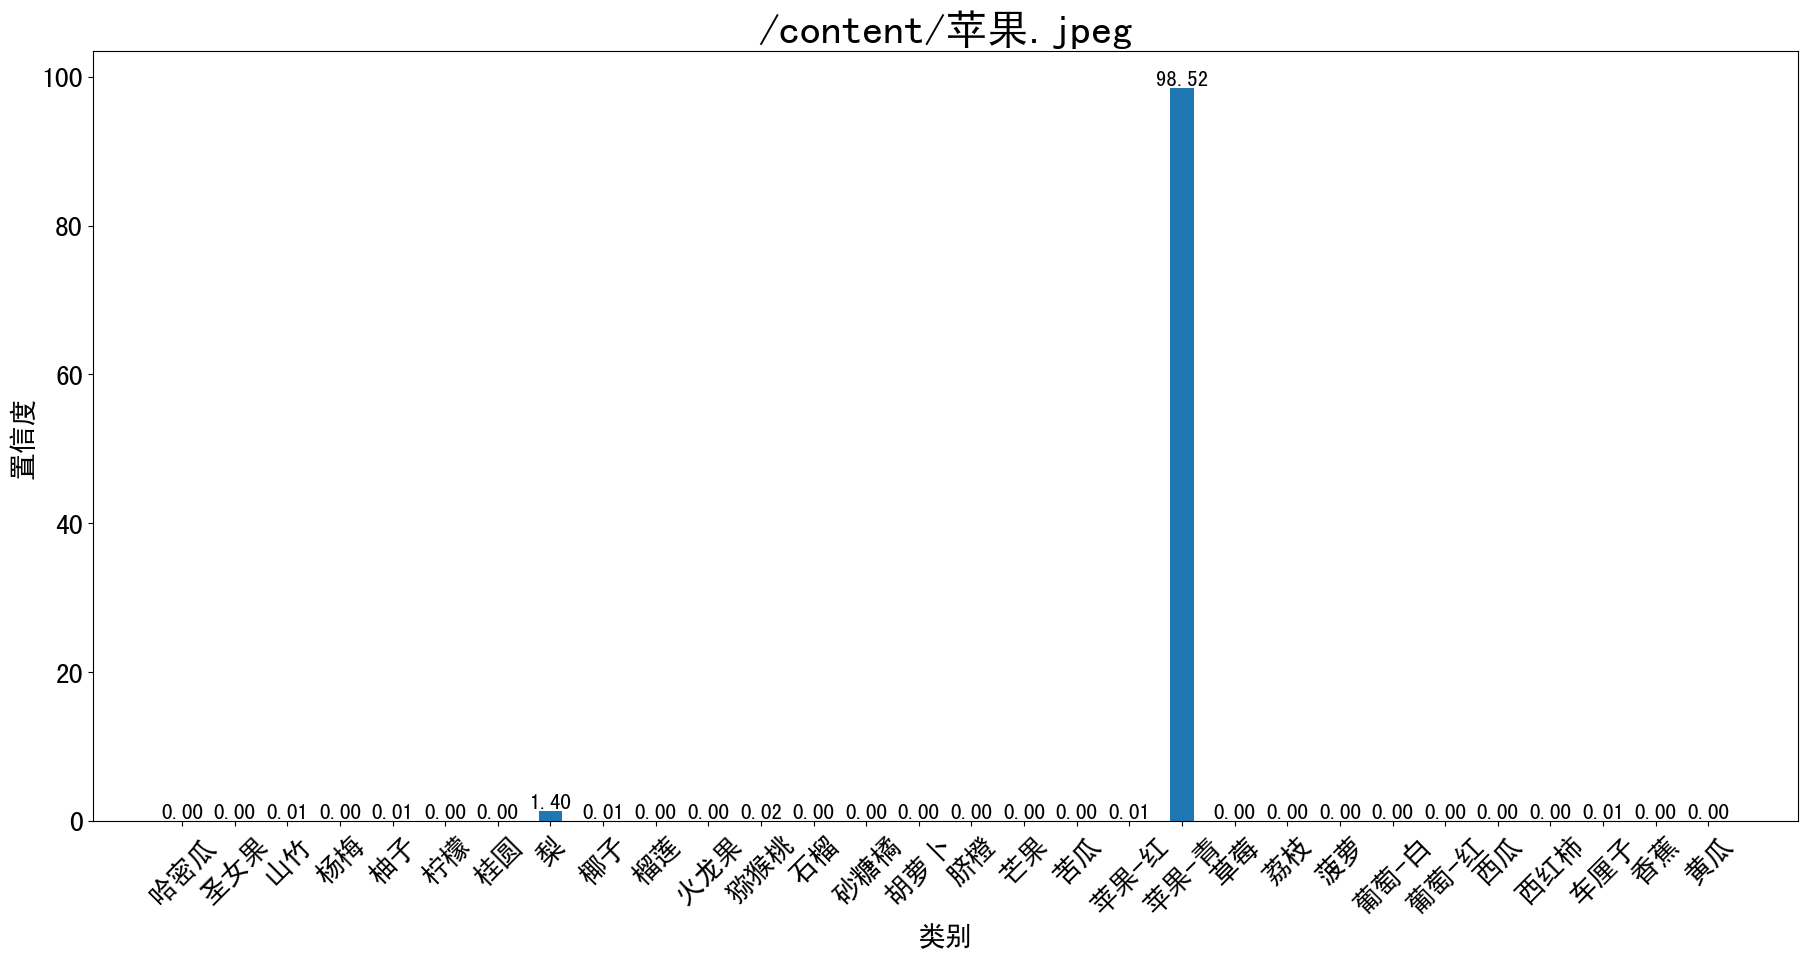

In [ ]:
plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.show()

In [ ]:
n = 10
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [ ]:
pred_ids

array([19,  7, 11,  8,  4,  2, 18, 27, 16,  5])

In [ ]:
confs

array([9.8518860e-01, 1.3979782e-02, 1.8367097e-04, 1.4499726e-04,
       1.0121436e-04, 8.8616282e-05, 8.2835162e-05, 5.8525780e-05,
       3.5291770e-05, 3.0970721e-05], dtype=float32)

In [ ]:
pred_df = pd.DataFrame() # 预测结果表格
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    label_idx = int(pred_ids[i]) # 获取类别号
    confidence = confs[i] * 100 # 获取置信度
    pred_df = pred_df.append({'Class':class_name, 'Class_ID':label_idx, 'Confidence(%)':confidence}, ignore_index=True) # 预测结果表格添加一行
display(pred_df) # 展示预测结果表格

,Class,Class_ID,Confidence(%)
0,苹果-青,19,98.518860
1,梨,7,1.397978
2,猕猴桃,11,0.018367
3,椰子,8,0.014500
4,柚子,4,0.010121
5,山竹,2,0.008862
6,苹果-红,18,0.008284
7,车厘子,27,0.005853
8,芒果,16,0.003529
9,柠檬,5,0.003097


In [ ]:
model = torch.load('/content/checkpoint/best-0.879.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)

In [ ]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [ ]:
def custom_sort():
    # 输入元素数量和列表元素
    N = int(input())
    numbers = []
    for _ in range(N):
        numbers.append(int(input()))

    # 输入A
    A = int(input())

    # 确保A在范围内
    if A >= N or A < 0:
        return

    print(numbers)  # 打印原始列表
    for i in range(A + 1):
        for j in range(i + 1, A + 1):
            if numbers[j] > numbers[i]:
                numbers[i], numbers[j] = numbers[j], numbers[i]  # 交换
                print(numbers)  # 打印每次交换后的列表

# 运行函数
custom_sort()



输入元素数量 (N): 7
输入一个数字: 3
输入一个数字: 2
输入一个数字: 0
输入一个数字: 6
输入一个数字: 7
输入一个数字: 9
输入一个数字: 1
输入A: 4
[3, 2, 0, 6, 7, 9, 1]
[6, 2, 0, 3, 7, 9, 1]
[7, 2, 0, 3, 6, 9, 1]
[7, 3, 0, 2, 6, 9, 1]
[7, 6, 0, 2, 3, 9, 1]
[7, 6, 2, 0, 3, 9, 1]
[7, 6, 3, 0, 2, 9, 1]
[7, 6, 3, 2, 0, 9, 1]
